<a href="https://colab.research.google.com/github/T0B1K/BrailleGloveStatistics/blob/main/study1/experiment/study1_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Constants

In [1]:
import seaborn as sns
import re
import pandas as pd

pastel_colors = sns.color_palette("pastel", 3)

# Define the order for the conditions and map them to the pastel colors
condition_order = ["Stroke", "Tap", "Vibration"]
condition_palette = {
    "Stroke": pastel_colors[0],  # First color in the pastel palette
    "Tap": pastel_colors[1],     # Second color in the pastel palette
    "Vibration": pastel_colors[2]  # Third color in the pastel palette
}
sns.set(style="whitegrid")

# Example usage
participantDataOrder = [
    (1,"STV.txt", "STV"), (2,"SVT.txt", "SVT"), (3,"TVS.txt", "TVS"), (4,"TSV.txt", "TSV"),
    (5,"VTS.txt", "VTS"), (6,"VST.txt", "VST"), (7,"STV2.txt", "STV"), (8,"SVT2.txt", "SVT"),
    (9,"TVS2.txt", "TVS"), (10,"VTS2.txt", "VTS"), (11,"TSV2.txt", "TSV"), (12,"VST2.txt", "VST")
]

# Predefined mappings
braille_character = {
    't': '⠞ (T)', 'h': '⠓ (H)', 'e': '⠑ (E)', 'o': '⠕ (O)', 'l': '⠇ (L)', 'd': '⠙ (D)',
    'p': '⠏ (P)', 'u': '⠥ (U)', 'b': '⠃ (B)', 'the': '⠞⠓⠑ (THE)', 'old': '⠕⠇⠙ (OLD)', 'pub': '⠏⠥⠃ (PUB)'
}

keyset = ["s", "d", "f", "j", "k", "l"]

numbers_encoding = {char: f'({i+1}) [{char.upper()}]' for i, char in enumerate('fdsjkl')}

setMapper = {key: set(value) for key, value in {
    "t": ["d", "s", "j", "k"], "h": ["f", "d", "k"], "e": ["f", "k"], "o": ["f", "s", "k"],
    "l": ["f", "d", "s"], "d": ["f", "j", "k"], "p": ["f", "d", "s", "j"], "u": ["f", "s", "l"], "b": ["f", "d"]
}.items()}

## Load Data

In [2]:


def getPandasDataFrameFromText(name: str):
    try:
        with open(name, "r") as file:
            text = file.read()
    except FileNotFoundError:
        print("File not found.")
        return pd.DataFrame()

    pattern = re.compile(r"Test\s+(\S+)\s+Submitted Value\s+(.+?)\s+Test Time \(ms\)\s+(\d+)", re.DOTALL)
    return pd.DataFrame([
        {"Test": test, "Submitted Value": submitted_value.strip(), "Test Time (ms)": int(test_time)}
        for test, submitted_value, test_time in pattern.findall(text)
    ])

def jaccard_coefficient(set1, set2):
    """Calculate the Jaccard coefficient between two sets."""
    return len(set1.intersection(set2)) / len(set1.union(set2))

def deciderFunction(df, sequence):
    conditions = {'t': 0, 'h': 0, 'e': 0, 'the': 0, 'o': 1, 'l': 1, 'd': 1, 'old': 1, 'p': 2, 'u': 2, 'b': 2, 'pub': 2}
    return sequence[conditions.get(df, -1)] if df in conditions else None

def splitDataset(participantDataOrder):
    dataframe_list = []

    for tuples in participantDataOrder:
        dataframe = getPandasDataFrameFromText(tuples[1])
        dataframe['ParticipantID'] = tuples[0]
        dataframe['Condition'] = dataframe["Test"].apply(lambda x: deciderFunction(x, tuples[2]))
        dataframe_list.append(dataframe)

    dataframe = pd.concat(dataframe_list, ignore_index=True)

    # Split dataset into two parts based on the 'Test' value
    dataframe_no_tests = dataframe[~dataframe['Test'].isin(['test', 'the', 'old', 'pub'])]
    dataframe_no_tests["jaccard_coefficient"] = dataframe_no_tests.apply(
        lambda row: jaccard_coefficient(set(row["Submitted Value"]), setMapper[row["Test"]]), axis=1
    )
    dataframe_no_tests = dataframe_no_tests.loc[dataframe_no_tests.groupby(['Condition', 'Test', 'ParticipantID'])['jaccard_coefficient'].idxmax()]

    dataframe_tests = dataframe[dataframe['Test'].isin(['the', 'old', 'pub'])]

    return dataframe_no_tests, dataframe_tests

def filterDataFrame(value: str, df, column: str):
    return df[df[column] == value]

def jaccard_word_score(word: str, test_word: str):
    if len(test_word) != len(word.split()):
        return 0
    return sum(jaccard_coefficient(set(w), setMapper[t]) for w, t in zip(word.split(), test_word)) / len(test_word)

def getMaxJaccardDataFrame(dataframe_tests, condition):
    # Filter the DataFrame by condition
    dataframe_filtered = dataframe_tests[(dataframe_tests['Test'].isin(['the', 'old', 'pub'])) & (dataframe_tests['Condition'] == condition)]

    # Copy the filtered DataFrame
    dataframe_copy = dataframe_filtered.copy()

    # Apply the Jaccard word score
    dataframe_copy["jaccard_word_score"] = dataframe_copy.apply(
        lambda row: jaccard_word_score(row["Submitted Value"], row["Test"]), axis=1
    )

    # Get the row with the maximum Jaccard score for each ParticipantID and Test
    return dataframe_copy.loc[dataframe_copy.groupby(['ParticipantID', 'Test'])['jaccard_word_score'].idxmax()]



In [3]:

dataframe_no_tests, dataframe_tests = splitDataset(participantDataOrder)

dataframe_tests_V_maxJaccard = getMaxJaccardDataFrame(dataframe_tests, "V")
dataframe_tests_S_maxJaccard = getMaxJaccardDataFrame(dataframe_tests, "S")
dataframe_tests_T_maxJaccard = getMaxJaccardDataFrame(dataframe_tests, "T")

dataframe_no_tests_s = filterDataFrame("S", dataframe_no_tests, "Condition")
dataframe_no_tests_t = filterDataFrame("T", dataframe_no_tests, "Condition")
dataframe_no_tests_v = filterDataFrame("V", dataframe_no_tests, "Condition")

<ipython-input-2-0d40615d19a0>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_no_tests["jaccard_coefficient"] = dataframe_no_tests.apply(


## Analyse Data

In [4]:

def get_TP(submitted_value, tested_character):
  return len(set(submitted_value) & setMapper[tested_character])

def get_FP(submitted_value, tested_character):
  return len(set(submitted_value) - setMapper[tested_character])

def get_FN(submitted_value, tested_character):
  return len(setMapper[tested_character] - set(submitted_value))

def precision(submitted_value, tested_character):
  return get_TP(submitted_value, tested_character) / (get_TP(submitted_value, tested_character) + get_FP(submitted_value, tested_character))

def recall(submitted_value, tested_character):
  return get_TP(submitted_value, tested_character) / (get_TP(submitted_value, tested_character) + get_FN(submitted_value, tested_character))

def f1_score(submitted_value, tested_character):
  prec = precision(submitted_value, tested_character)
  rec = recall(submitted_value, tested_character)
  divisor = prec + rec
  f1 = 0
  if divisor != 0:
    f1 = 2 * (prec * rec) / divisor
  return f1


def evaluateData(value, test, condition):
    """Computes various evaluation metrics for submitted values against test characters."""
    return [
        (
            f1_score(submitted_value, tested_character),
            precision(submitted_value, tested_character),
            recall(submitted_value, tested_character),
            get_TP(submitted_value, tested_character),
            get_FP(submitted_value, tested_character),
            set(submitted_value),
            setMapper[tested_character],
            setMapper[tested_character] - set(submitted_value),
            set(submitted_value) - setMapper[tested_character],
            tested_character,
            condition,
            jaccard_coefficient(set(submitted_value), setMapper[tested_character])
        )
        for submitted_value, tested_character in zip(value.split(), test)
    ]


def evaluateDataFrames(dataframes):
    """Applies evaluateData to all provided DataFrames and aggregates results."""
    compareCharacters = []

    for df in dataframes:
        df.apply(lambda row: compareCharacters.extend(
            evaluateData(row["Submitted Value"], row["Test"], row["Condition"])
        ), axis=1)

    columns = [
        'F1', 'Precision', 'Recall', 'TP', 'FP', 'Submitted Value',
        'Ground Truth', 'Missed Character', 'Surplus Character',
        'Tested Character', 'Condition', 'Jaccard Score'
    ]

    return pd.DataFrame(compareCharacters, columns=columns)

In [5]:
data = [dataframe_tests_V_maxJaccard, dataframe_tests_S_maxJaccard, dataframe_tests_T_maxJaccard]
df = evaluateDataFrames(data)

## Test Compare

### Boxplot Code

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
from scipy.stats import kruskal

def plot_boxplot_with_swarmplot(data, score, test, i):
    """
    Plot the boxplot for a given test with a swarmplot on top.

    Parameters:
        data (pd.DataFrame): Data filtered for the specific test.
        score (str): The score column to plot.
        test (str): The test name for the title.
        i (int): The index of the subplot.
    """
    # Plot the boxplot
    sns.boxplot(
        x='Condition',
        y=score,
        data=data,
        showfliers=False,
        palette=condition_palette,
        order=condition_order,
        width=0.7,
        dodge=False,  # Keep all conditions in the same box plot
        medianprops={'color': '#6E6E6E', 'linewidth': 2},
        hue='Condition'
    )

    # Add swarmplot on top of the boxplot
    sns.swarmplot(
        x='Condition',
        y=score,
        data=data,
        color='black',  # 'k' stands for black, or you can customize the color
        alpha=0.6,  # Adjust transparency
        size=3,  # Adjust size of the points
        dodge=False  # Keep all points on top of each box
    )

    # Customize the plot for the current test
    plt.title(f"{braille_character[test]}", fontsize=12)
    plt.xlabel('Stimulus')
    if i == 0:
        plt.ylabel(score.replace('_', ' ').title())  # Add y-axis label for the first plot
    else:
        plt.ylabel('')  # Remove y-axis label for other plots
    # Set the y-axis range from 0 to 1
    plt.ylim(0, 1)
def perform_tests(test_data, test, score):
  print_medians(test_data, test, score)
  conditions_data = [test_data[test_data['Condition'] == condition][score].values for condition in test_data['Condition'].unique()]
  perform_levenes(conditions_data)
  kruskal_H, p_value_kruskal = perform_kruskal(conditions_data)
  calculate_eta_squared(kruskal_H, conditions_data)
  if p_value_kruskal < 0.05:
    perform_posttest(conditions_data)
  print("\n\n")

def perform_levenes(conditions_data):
  stat_levene, p_value_levene = stats.levene(*conditions_data)
  print(f"Levene's Test: p-value = {p_value_levene}, stat: {stat_levene} -> Homogeneity of variances: {p_value_levene > 0.05}")

def perform_kruskal(condition_data):
  H, p_value_kruskal = stats.kruskal(*condition_data)
  print(f"Kruskal-Wallis: H-stat: {H:.4f}, p-value: {p_value_kruskal:.4f}\tSignificant difference between datasets: {p_value_kruskal < 0.05}")
  return H, p_value_kruskal

def calculate_eta_squared(kruskal_H, conditions_data):
  N = sum(len(group) for group in conditions_data)  # Return H, p_value, k, N
  eta_squared = kruskal_H / (N - 1)
  print(f"eta_squared: {eta_squared}")

def perform_posttest(condition_data):
  from statsmodels.stats.multicomp import pairwise_tukeyhsd
  all_data = np.concatenate(condition_data)
  labels = np.concatenate([[f"Condition {i+1}" for _ in range(len(d))] for i, d in enumerate(data)])
  tukey = pairwise_tukeyhsd(all_data, labels, alpha=0.05)
  print(tukey)

def print_medians(test_data, test, score):
  print(f"Medians for '{test}':")
  for condition in test_data['Condition'].unique():
      condition_data = test_data[test_data['Condition'] == condition]
      median = condition_data[score].median()
      print(f"  {condition}: {median}")

def print_boxplots_and_tests_new(data, score="jaccard_coefficient", pdf_name = "", plotting_order = [], groupable = True):
    pivot_df = data
    if groupable:
      pivot_df = data[['Test', 'Condition', 'ParticipantID', score]]
    pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)
    plt.figure(figsize=(15, 10))

    for i, test in enumerate(plotting_order):
        plt.subplot(3, 3, i + 1)

        if groupable:
          test_data = pivot_df[pivot_df['Test'] == test]
        else:
          test_data = pivot_df[pivot_df['Tested Character'] == test]

        plot_boxplot_with_swarmplot(test_data, score, test, i)
        perform_tests(test_data, test, score)

    plt.tight_layout()
    plt.savefig(f'/content/{pdf_name}.pdf', format='pdf')



### Boxplots for the Learning phase

<ipython-input-6-bcc2127a7d9e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)


Medians for 't':
  Stroke: 0.575
  Tap: 0.4642857142857143
  Vibration: 0.6333333333333333
Levene's Test: p-value = 0.04162262443493394, stat: 4.620700382188248 -> Homogeneity of variances: False
Kruskal-Wallis: H-stat: 1.9406, p-value: 0.3790	Significant difference between datasets: False
eta_squared: 0.1764184397163122



Medians for 'h':
  Stroke: 0.7083333333333333
  Tap: 0.5
  Vibration: 0.6666666666666666
Levene's Test: p-value = 0.5805056695008444, stat: 0.5780849974398363 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 2.2817, p-value: 0.3195	Significant difference between datasets: False
eta_squared: 0.20742753623188437



Medians for 'e':
  Stroke: 0.6666666666666666
  Tap: 0.3333333333333333
  Vibration: 0.5
Levene's Test: p-value = 0.6286381324542634, stat: 0.4889867841409693 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 1.1068, p-value: 0.5750	Significant difference between datasets: False
eta_squared: 0.10062240663900403



Medians for 'o':
  Stroke:

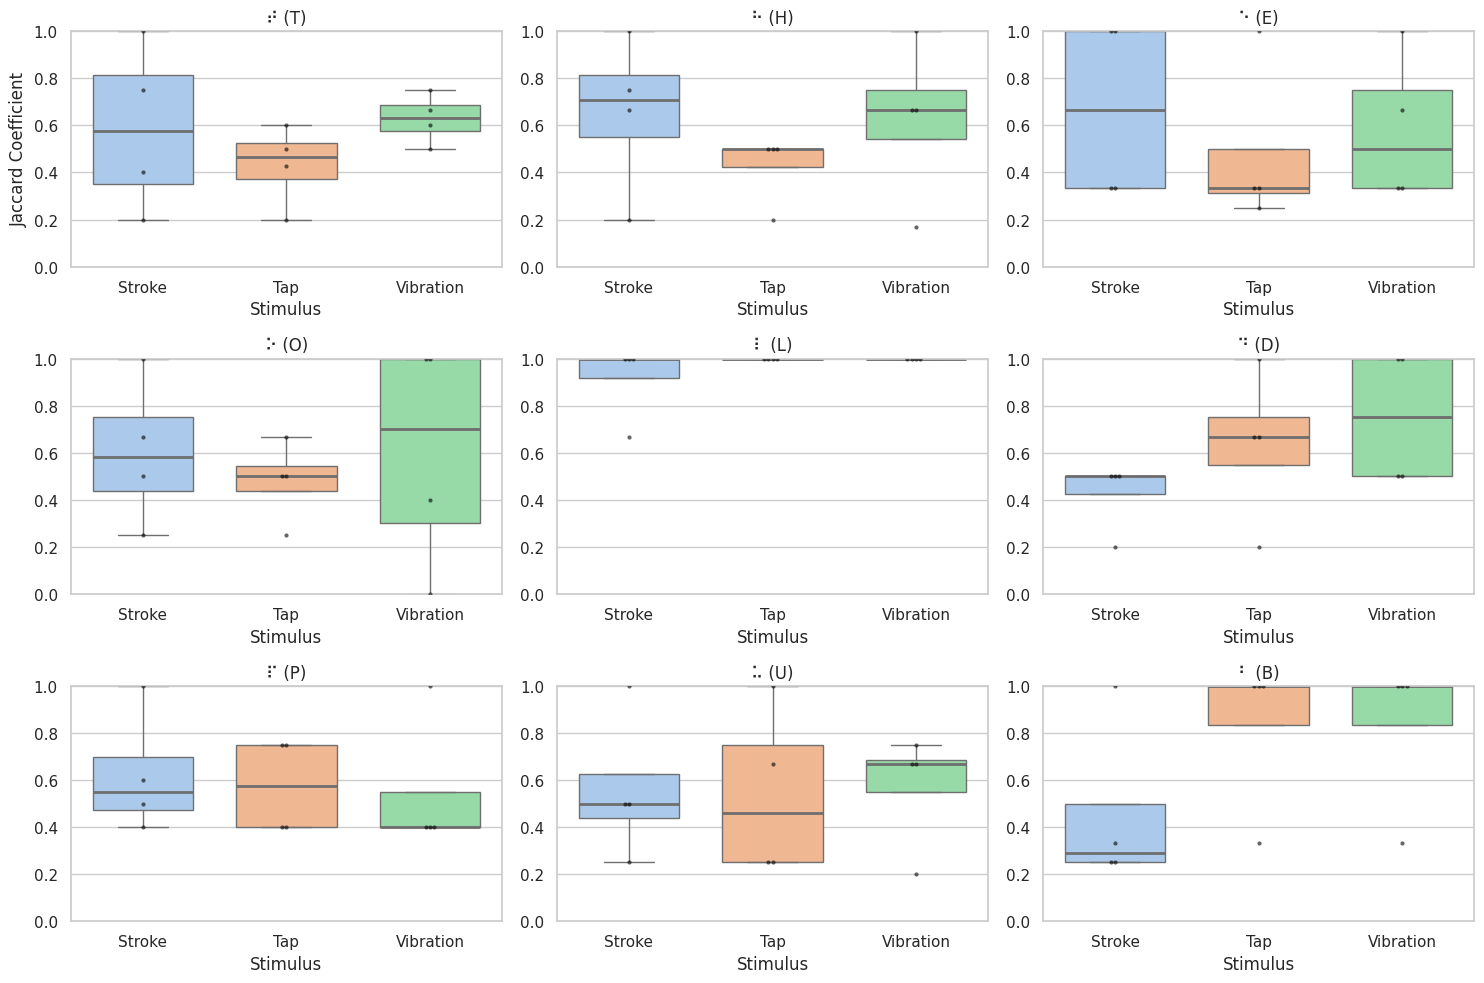

In [7]:
print_boxplots_and_tests_new(dataframe_no_tests.copy(), pdf_name="Test_single_char", plotting_order=["t", "h", "e", "o", "l", "d", "p", "u", "b"])

# Test results

### Boxplot for the Test words

<ipython-input-6-bcc2127a7d9e>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df.replace({"T": "Tap", "S": "Stroke", "V": "Vibration"}, inplace=True)


Medians for 'the':
  Vibration: 0.4277777777777777
  Stroke: 0.35555555555555557
  Tap: 0.43055555555555547
Levene's Test: p-value = 0.2867659297438969, stat: 1.4661066785671097 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 0.0361, p-value: 0.9821	Significant difference between datasets: False
eta_squared: 0.0036149162861494437



Medians for 'old':
  Vibration: 0.6499999999999999
  Stroke: 0.47777777777777775
  Tap: 0.6222222222222222
Levene's Test: p-value = 0.6835581472608754, stat: 0.39912320522963946 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 3.9736, p-value: 0.1371	Significant difference between datasets: False
eta_squared: 0.3973623853211009



Medians for 'pub':
  Vibration: 0.611111111111111
  Stroke: 0.4583333333333333
  Tap: 0.5333333333333333
Levene's Test: p-value = 0.7898889216691855, stat: 0.2421536327379923 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 1.0569, p-value: 0.5895	Significant difference between datasets: False
eta_squar

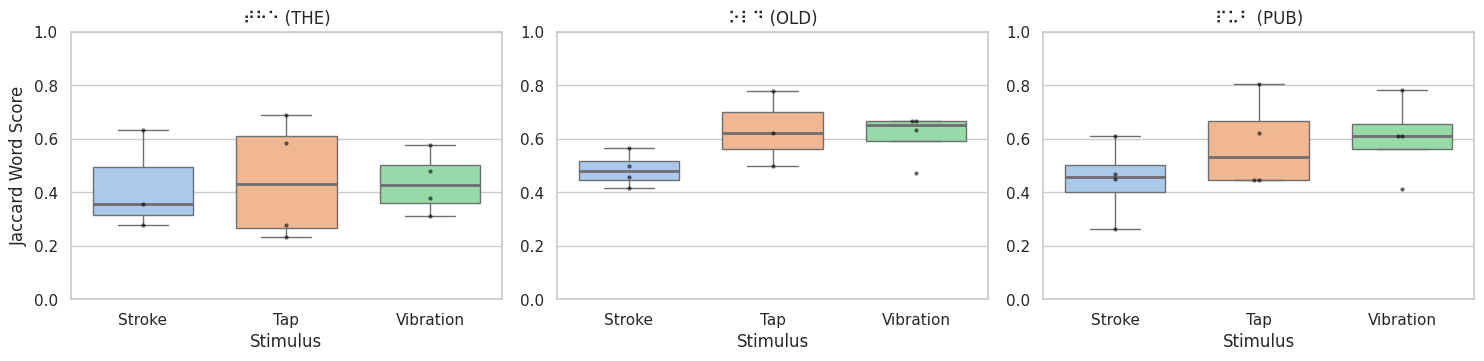

In [8]:
print_boxplots_and_tests_new(pd.concat(data.copy(), ignore_index=True), score="jaccard_word_score", pdf_name="JaccardTest", plotting_order=["the", "old", "pub"])

# Specific character investigation

### Boxplots for the specific characters in the **tested words**

Medians for 't':
  Vibration: 0.5
  Stroke: 0.4
  Tap: 0.5
Levene's Test: p-value = 0.34782524696636263, stat: 1.208584518929346 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 1.0203, p-value: 0.6004	Significant difference between datasets: False
eta_squared: 0.10203252032520346



Medians for 'h':
  Vibration: 0.30000000000000004
  Stroke: 0.5
  Tap: 0.43333333333333335
Levene's Test: p-value = 0.9413124291562092, stat: 0.06093972092650799 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 0.0136, p-value: 0.9932	Significant difference between datasets: False
eta_squared: 0.0013629283489098786



Medians for 'e':
  Vibration: 0.3333333333333333
  Stroke: 0.3333333333333333
  Tap: 0.3333333333333333
Levene's Test: p-value = 0.4985302467386891, stat: 0.7603305785123967 -> Homogeneity of variances: True
Kruskal-Wallis: H-stat: 0.0979, p-value: 0.9522	Significant difference between datasets: False
eta_squared: 0.009790528233150821



Medians for 'o':
  Vibration: 0.5
  S

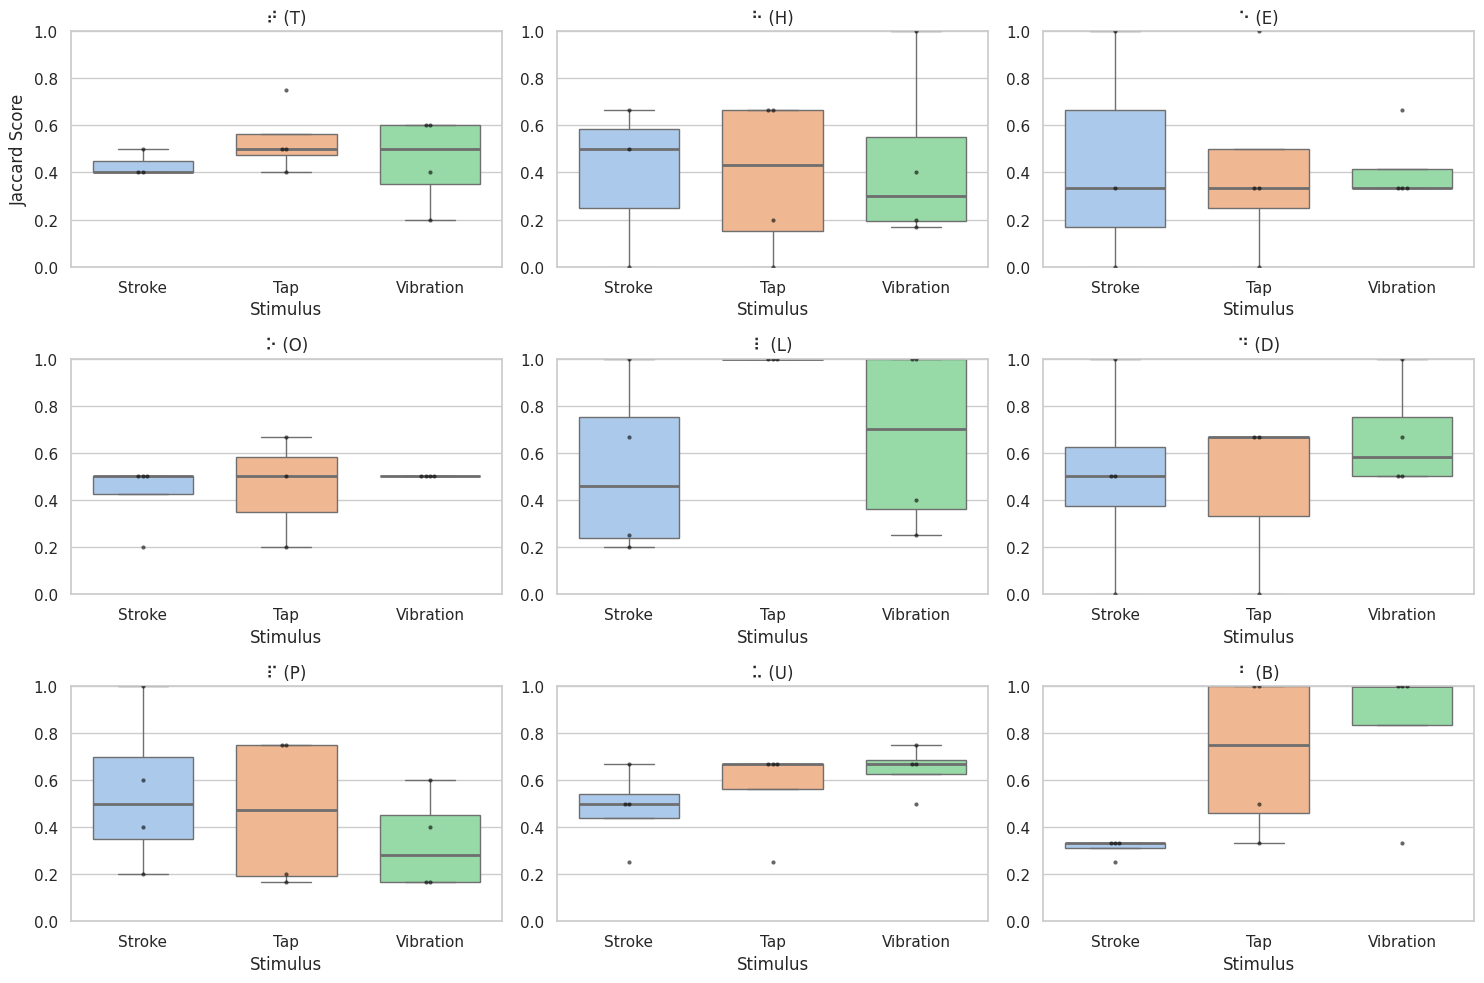

In [9]:
print_boxplots_and_tests_new(df, score="Jaccard Score", pdf_name="boxplot_with_swarm_single_chars_test", plotting_order=['t', 'h', 'e', 'o', 'l', 'd', 'p', 'u', 'b'], groupable=False)

## Investigation of the wrong Keypresses

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_character_counts_new(df):
    """Plot bar charts for 'Tested Character' and 'Surplus Character' counts per 'Condition'."""
    plt.figure(figsize=(15, 10))
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'DejaVu Sans'

    conditions = df['Condition'].unique()
    num_conditions = len(conditions)

    for i, condition in enumerate(conditions):
        condition_data = df[df['Condition'] == condition]

        for col, title, color, pos in zip(['Missed Character', 'Surplus Character'],
                                           ["FN (Missed)", "FP (Surplus)"],
                                           ["Blues_d", "Oranges_d"],
                                           [1, 2]):
            condition_data[col] = condition_data[col].apply(lambda x: [numbers_encoding.get(c, c) for c in list(x)])
            counts = condition_data[col].explode().value_counts()

            ax = plt.subplot(num_conditions, 2, i * 2 + pos)
            sns.barplot(x=counts.index, y=counts.values, palette=color, ax=ax)

            ax.set_title(f"{condition} - {title}", fontsize=14)
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel('Count', fontsize=12)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)

            for tick in ax.get_xticklabels():
                tick.set_fontname("DejaVu Sans")

    plt.tight_layout()
    plt.savefig('/content/columnChart.pdf', format='pdf')



<ipython-input-10-1c86a2a327be>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_data[col] = condition_data[col].apply(lambda x: [numbers_encoding.get(c, c) for c in list(x)])
<ipython-input-10-1c86a2a327be>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=color, ax=ax)
<ipython-input-10-1c86a2a327be>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
<ipython-input-10-1c86a2a327be>:21: SettingWithC

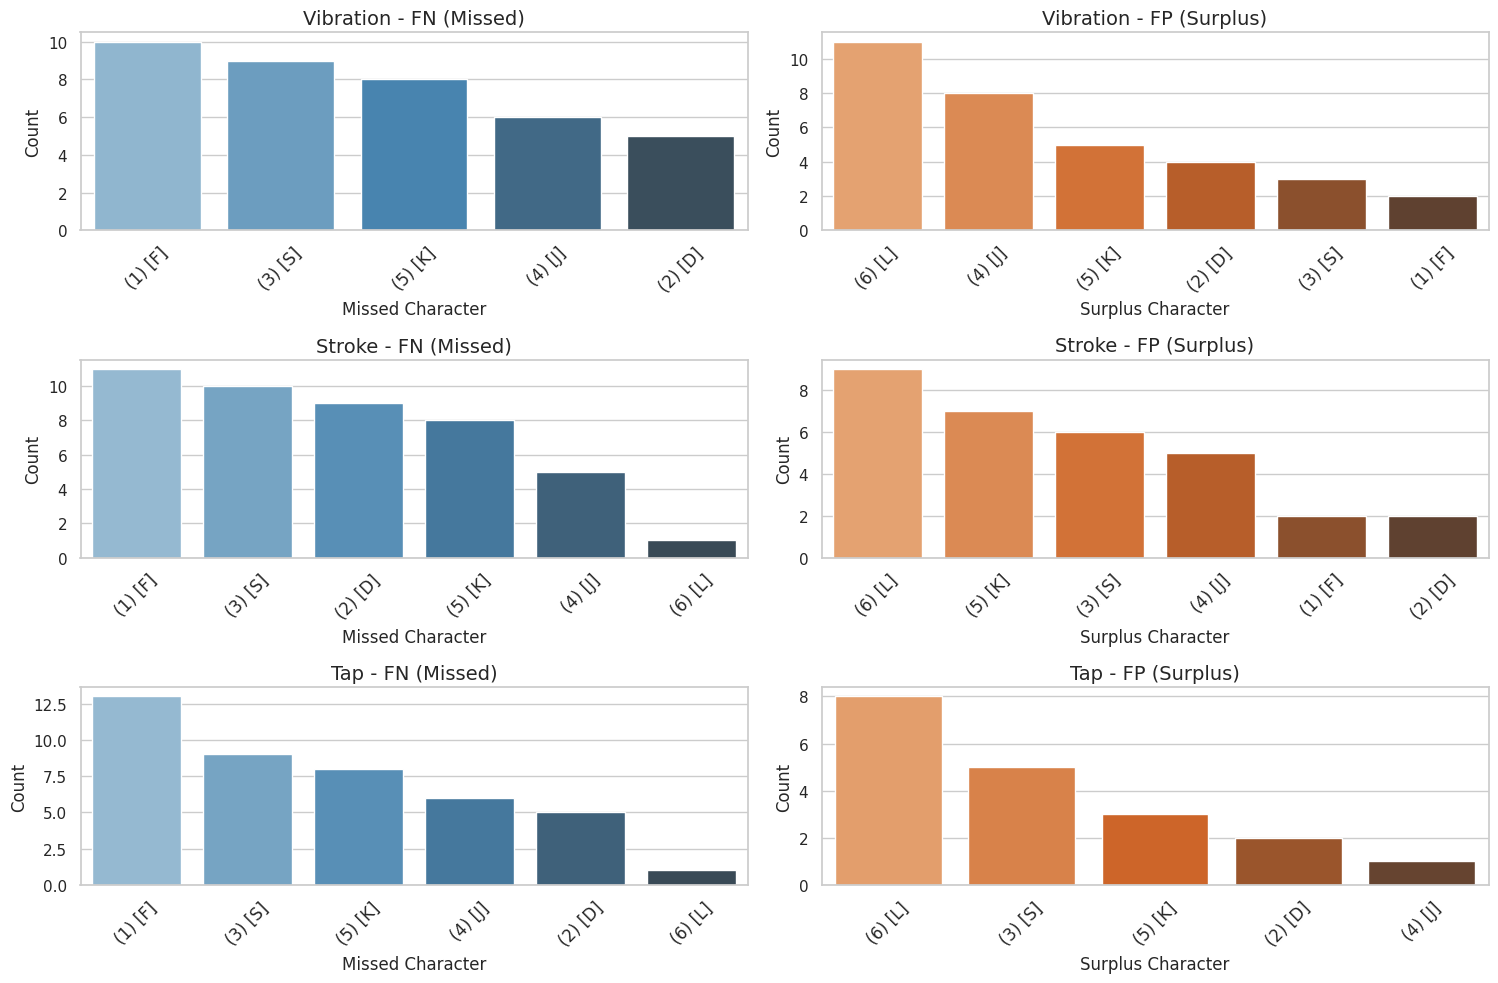

In [11]:
plot_character_counts_new(df[['Condition', 'Tested Character', 'Missed Character', 'Surplus Character', 'F1']])


## Wrong Keypresses **given Braille Character** plotted as Heatmap

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_matrix(condition_df, tested_chars):
  missed_char_matrix = {tested_char: {missed_char: 0 for missed_char in keyset} for tested_char in tested_chars}
  surplus_char_matrix = {tested_char: {surplus_char: 0 for surplus_char in keyset} for tested_char in tested_chars}
  total_tested_char_matrix = {tested_char: 0 for tested_char in tested_chars}

  # Loop through each row in the filtered dataframe to count the occurrences
  for _, row in condition_df.iterrows():
    tested_character = row['Tested Character']

    # Count occurrences of Missed Characters
    missed_chars = row['Missed Character']  # This is a set
    for missed_char in missed_chars:
        if missed_char in keyset:
            missed_char_matrix[tested_character][missed_char] += 1

    # Count occurrences of Surplus Characters
    surplus_chars = row['Surplus Character']  # This is a set
    for surplus_char in surplus_chars:
        if surplus_char in keyset:
            surplus_char_matrix[tested_character][surplus_char] += 1

    # Track the total occurrences of each Tested Character (for percentage calculation)
    total_tested_char_matrix[tested_character] += 1
  return total_tested_char_matrix, pd.DataFrame(missed_char_matrix), pd.DataFrame(surplus_char_matrix)


def calculate_percentages(missed_char_df, surplus_char_df, tested_chars, total_tested_char_matrix):
  missed_char_percentage_df = missed_char_df.copy()
  surplus_char_percentage_df = surplus_char_df.copy()

  for tested_char in tested_chars:
      total_tested_char = total_tested_char_matrix[tested_char]

      if total_tested_char > 0:
          missed_char_percentage_df[tested_char] = (missed_char_df[tested_char] / total_tested_char) * 100
          surplus_char_percentage_df[tested_char] = (surplus_char_df[tested_char] / total_tested_char) * 100
      else:
          missed_char_percentage_df[tested_char] = 0
          surplus_char_percentage_df[tested_char] = 0

  missed_char_percentage_df = missed_char_percentage_df.rename(index=braille_character, columns=braille_character)
  surplus_char_percentage_df = surplus_char_percentage_df.rename(index=braille_character, columns=braille_character)

  missed_char_percentage_df = missed_char_percentage_df.rename(index=numbers_encoding)
  surplus_char_percentage_df = surplus_char_percentage_df.rename(index=numbers_encoding)
  return missed_char_percentage_df, surplus_char_percentage_df


def generate_heatmap(sns, data, tested_chars, falseNegative = False, percentages = False):
  x_tick_labels = [braille_character.get(c, c) for c in tested_chars]
  y_tick_labels = [numbers_encoding.get(c, c) for c in keyset]
  fmt = ".1f" if percentages else "d"
  color = "Blues" if falseNegative else "Oranges"

  sns.heatmap(data, annot=True, cmap=color, fmt=fmt, cbar=False,
              xticklabels=x_tick_labels,
              yticklabels=y_tick_labels)


def generate_heatmap_plot(plt, plt_nr, data, tested_chars, percentages, condition):
  plt.subplot(1, 2, plt_nr)
  falseNegative = True if plt_nr == 1 else False
  generate_heatmap(sns, data, tested_chars, falseNegative=falseNegative, percentages=percentages)
  plt.title(f'{condition} - FN (Missed) Key(s)')
  plt.xlabel('Tested Character')
  plt.ylabel('FN (Missed) Key(s)')
  plt.xticks(rotation=45, ha="right")
  plt.yticks(rotation=0)


def plot_character_correlations_by_condition(df, percentages:bool, name:str):
    """
    Plot correlation matrices for each condition, showing the relationship between the 'Tested Character'
    and the 'Missed Character' and 'Surplus Character' with percentage values.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Condition', 'Tested Character',
                           'Missed Character', 'Surplus Character' columns.
    """

    tested_chars = ["t", "h", "e", "o", "l", "d", "p", "u", "b"]
    conditions = df['Condition'].unique()

    for condition in conditions:
        condition_df = df[df['Condition'] == condition]
        total_tested_char_matrix, missed_char_df, surplus_char_df = calculate_matrix(condition_df, tested_chars)
        missed_char_percentage_df, surplus_char_percentage_df = calculate_percentages(missed_char_df, surplus_char_df, tested_chars, total_tested_char_matrix)

        plt.figure(figsize=(15, 6))
        data = missed_char_percentage_df if percentages else missed_char_df
        generate_heatmap_plot(plt, 1, data, tested_chars, percentages, condition)

        data = surplus_char_percentage_df if percentages else surplus_char_df
        generate_heatmap_plot(plt, 2, data, tested_chars, percentages, condition)

        plt.tight_layout()
        plt.savefig(f'/content/heatmap_{condition}_{name}.pdf', format='pdf')


### Heatmap (counts)

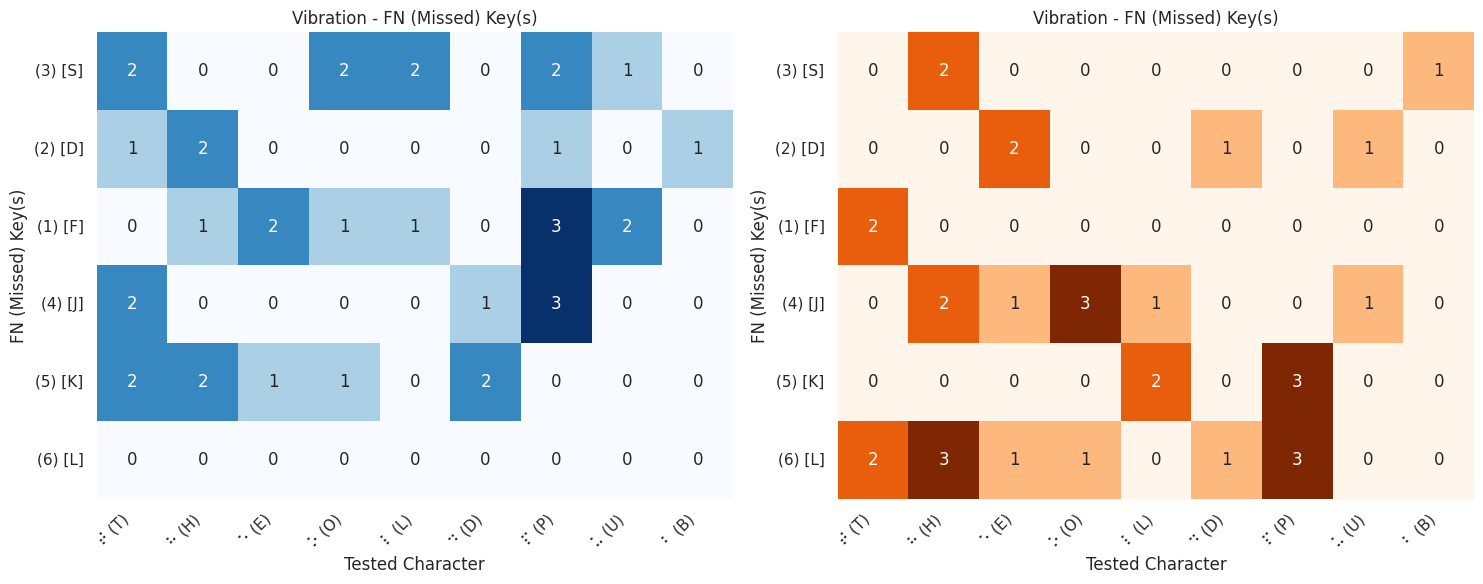

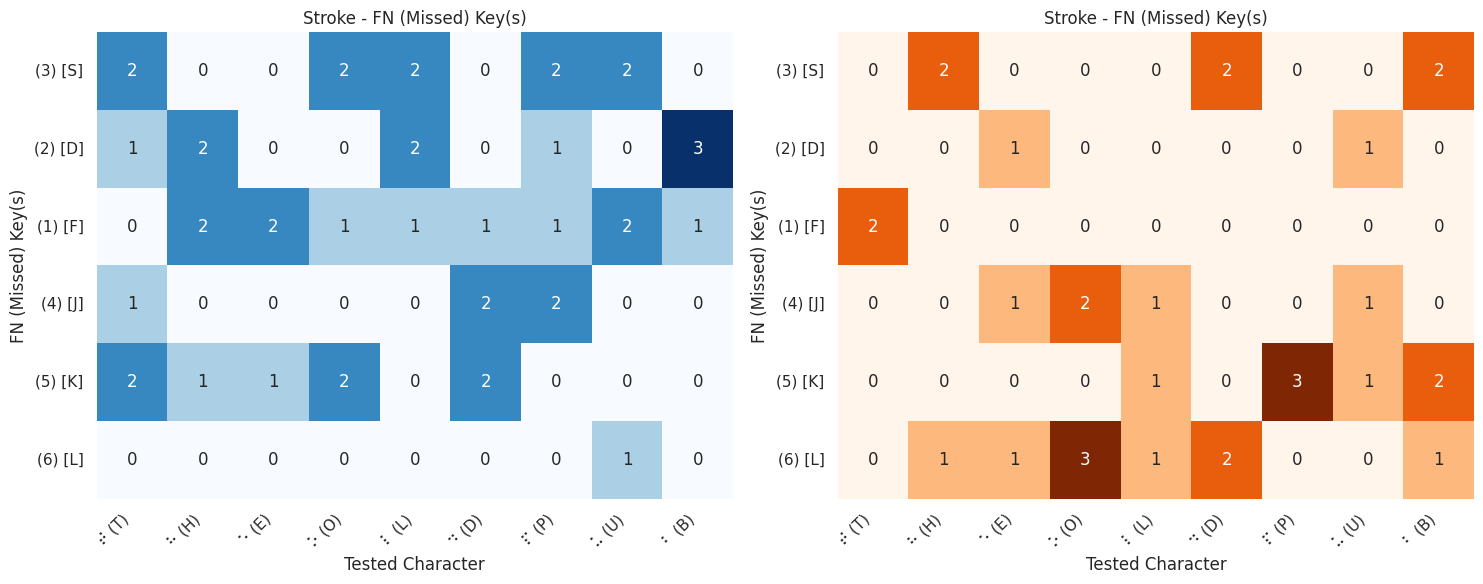

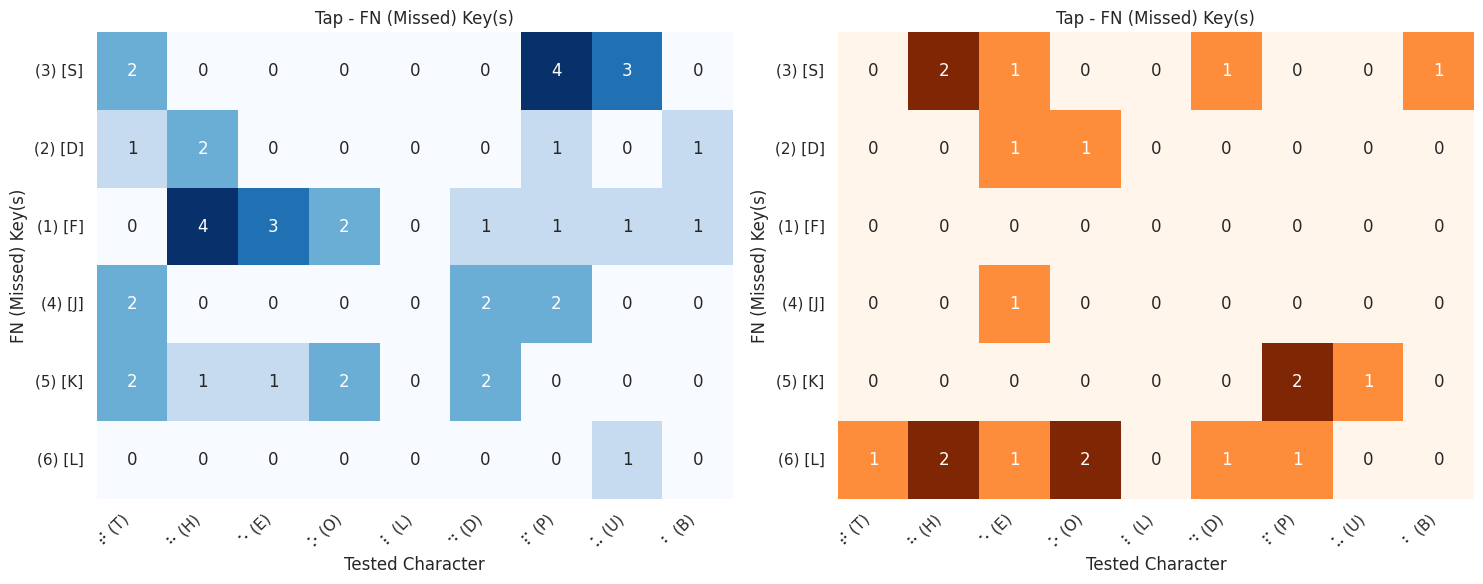

In [13]:
plot_character_correlations_by_condition(df, False, "counts")

### Heatmaps (percentages)

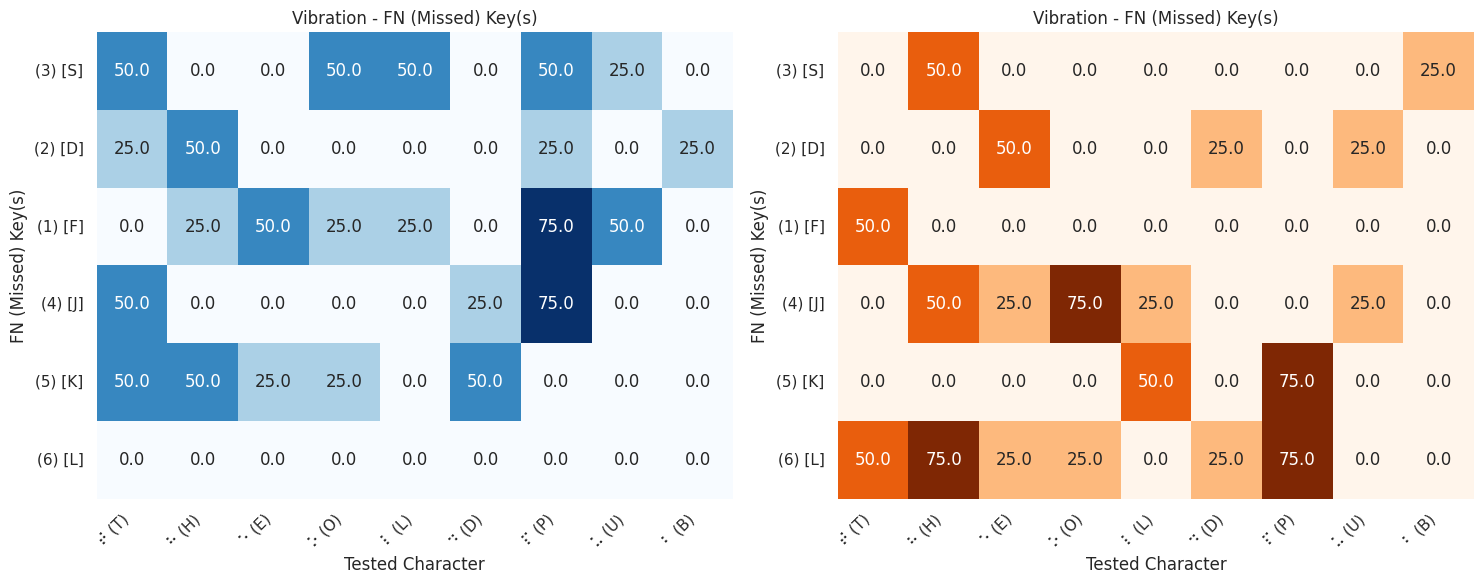

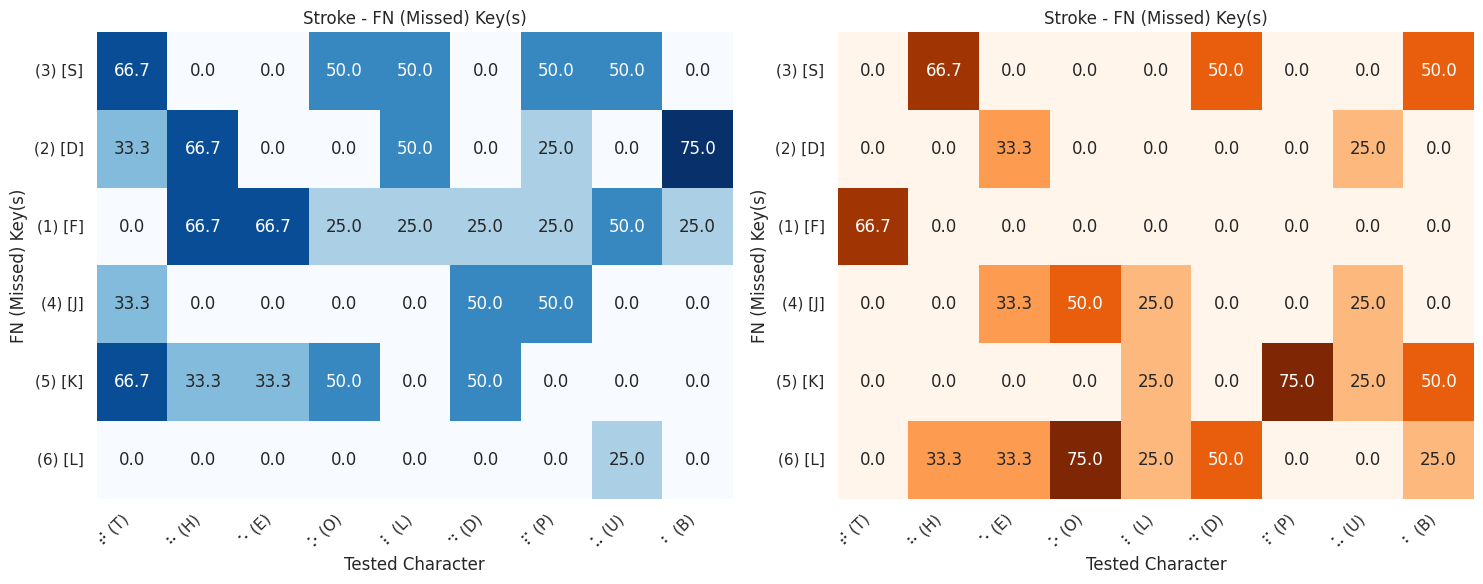

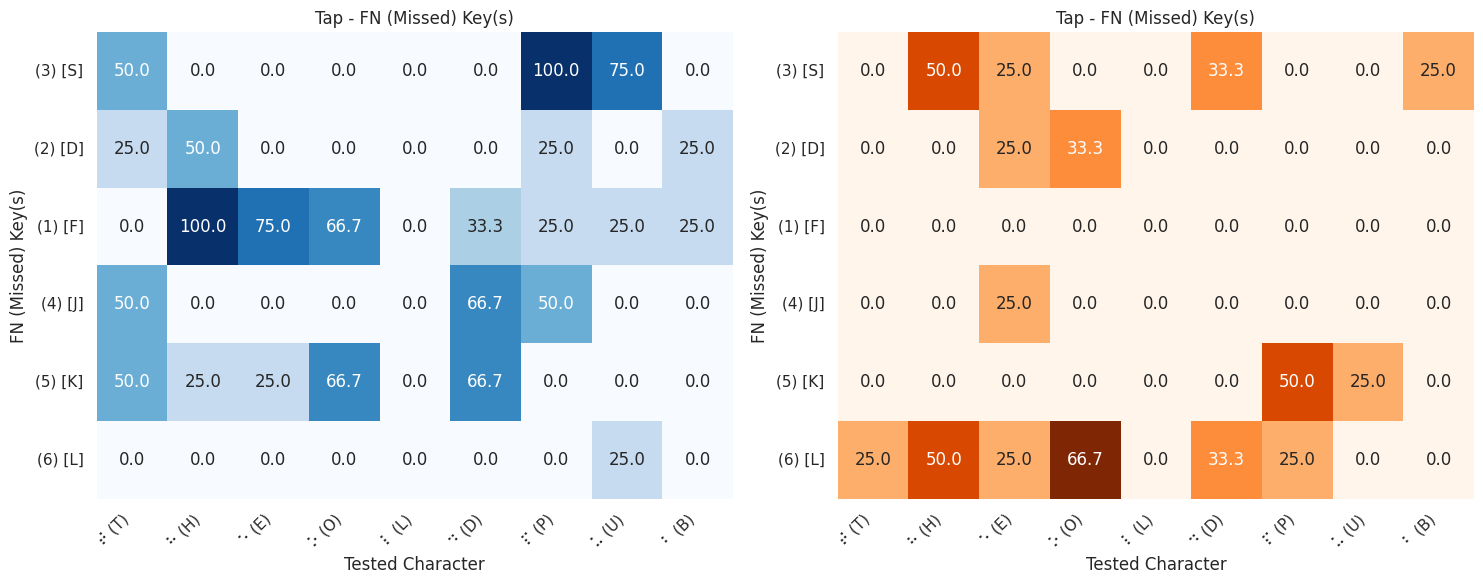

In [14]:
plot_character_correlations_by_condition(df, True, "testname2")

## Plot PLA

In [15]:
import pandas as pd

def one_hot_encode_submitted_value(df):
    """
    One-hot encode the 'Submitted Value' column in the dataframe.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Condition', 'Submitted Value', 'Ground Truth' columns.

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded 'Submitted Value'.
    """
    # Define the possible values for 'Submitted Value'
    possible_values = ["s", "d", "f", "j", "k", "l"]

    for value in possible_values:
        df[f"Submitted_Value_{value}"] = df['Submitted Value'].apply(lambda x: 1 if value in x else 0)

    return df

# Apply the one-hot encoding function
df_encoded = one_hot_encode_submitted_value(df)
df_encoded

,F1,Precision,Recall,TP,FP,Submitted Value,Ground Truth,Missed Character,Surplus Character,Tested Character,Condition,Jaccard Score,Submitted_Value_s,Submitted_Value_d,Submitted_Value_f,Submitted_Value_j,Submitted_Value_k,Submitted_Value_l
0,0.750000,0.750000,0.750000,3,1,"{k, d, f, s}","{j, d, f, s}",{j},{k},p,Vibration,0.600000,1,1,1,0,1,0
1,0.857143,0.750000,1.000000,3,1,"{l, d, f, s}","{l, f, s}",{},{d},u,Vibration,0.750000,1,1,1,0,0,1
2,1.000000,1.000000,1.000000,2,0,"{d, f}","{d, f}",{},{},b,Vibration,1.000000,0,1,1,0,0,0
3,0.666667,0.666667,0.666667,2,1,"{k, j, f}","{k, f, s}",{s},{j},o,Vibration,0.500000,0,0,1,1,1,0
4,1.000000,1.000000,1.000000,3,0,"{d, f, s}","{d, f, s}",{},{},l,Vibration,1.000000,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.000000,0.000000,0.000000,0,2,"{l, s}","{k, d, f}","{k, d, f}","{l, s}",h,Tap,0.000000,1,0,0,0,0,1
98,0.500000,0.500000,0.500000,1,1,"{k, l}","{k, f}",{f},{l},e,Tap,0.333333,0,0,0,0,1,1
99,0.857143,1.000000,0.750000,3,0,"{j, d, f}","{j, d, f, s}",{s},{},p,Tap,0.750000,0,1,1,1,0,0
100,0.400000,0.500000,0.333333,1,1,"{k, l}","{l, f, s}","{f, s}",{k},u,Tap,0.250000,0,0,0,0,1,1


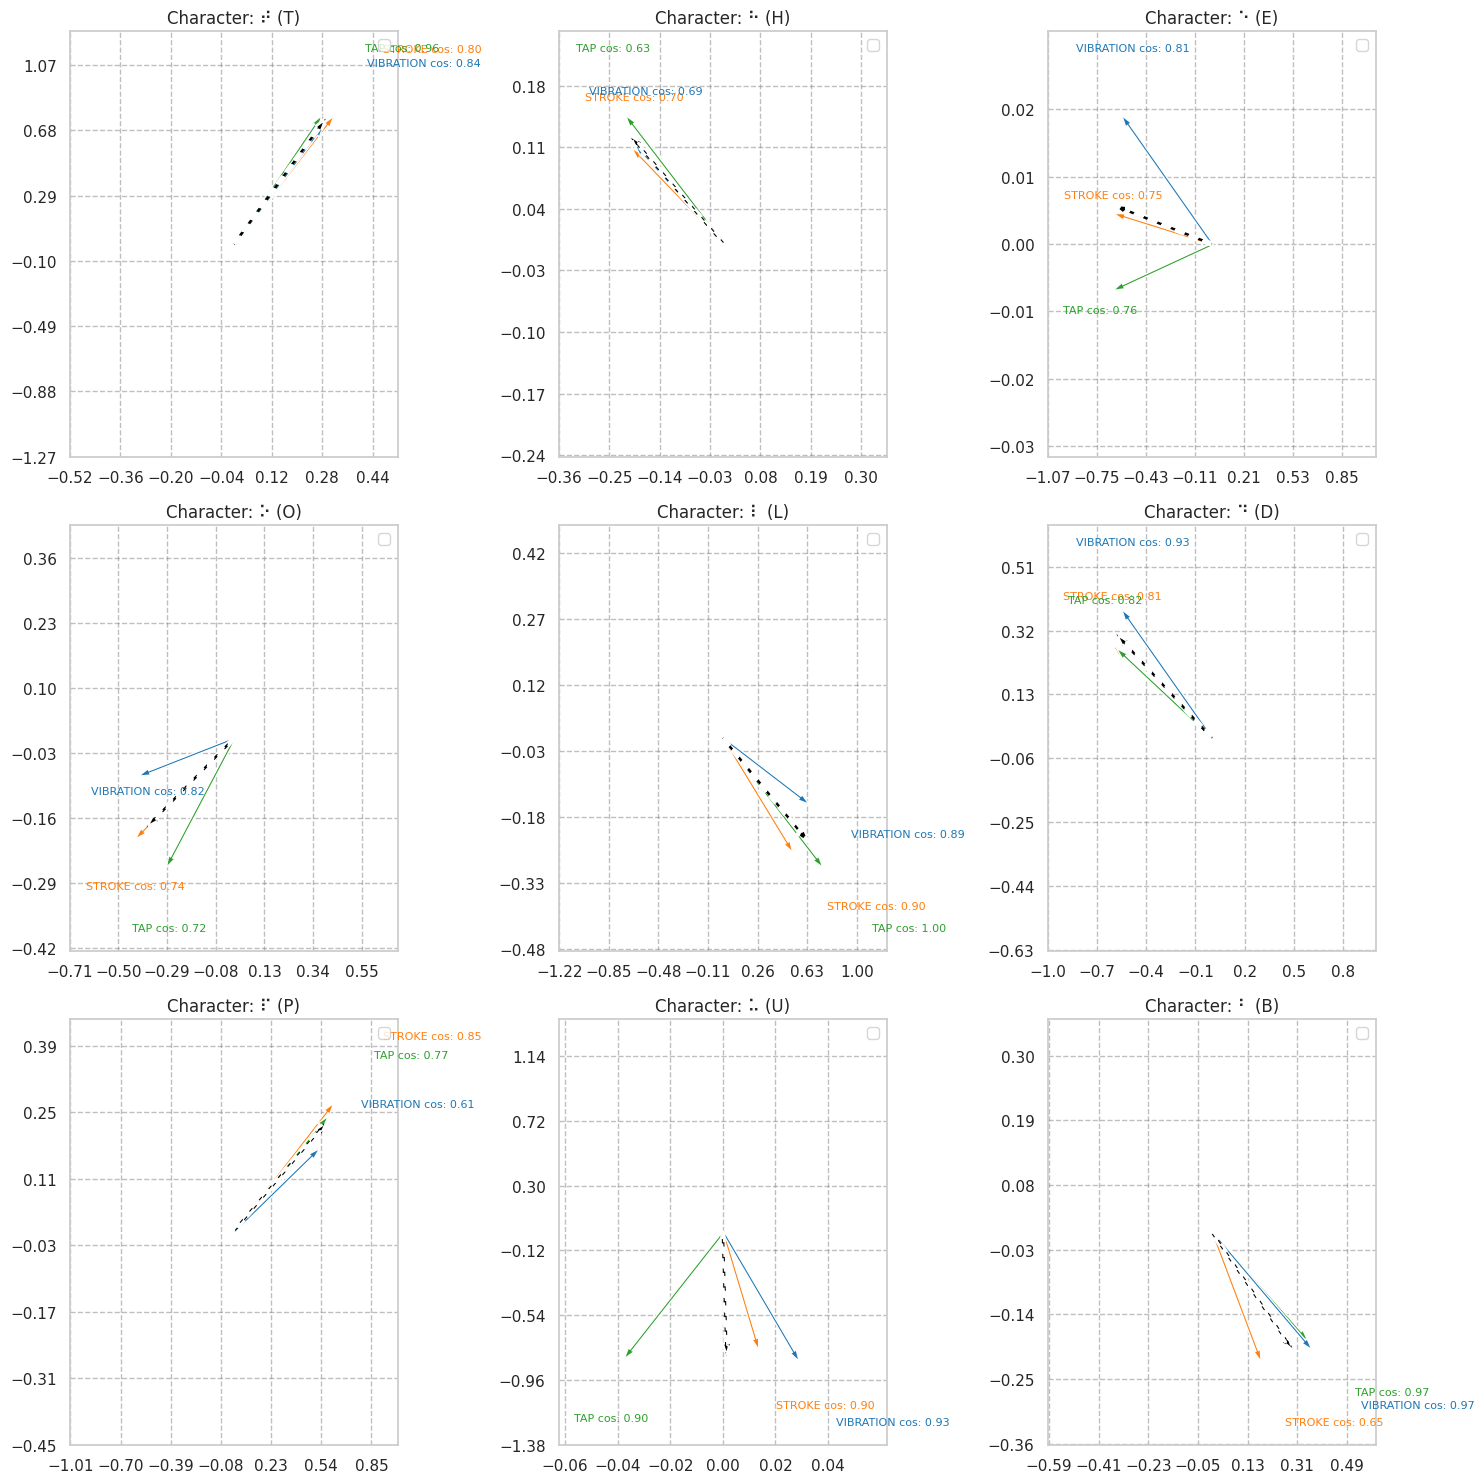

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

def one_hot_encode_submitted_value(df):
    """
    One-hot encode the 'Submitted Value' column in the dataframe.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Condition', 'Submitted Value', 'Ground Truth' columns.

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded 'Submitted Value' and 'Ground Truth'.
    """
    # Define the possible values for 'Submitted Value' and 'Ground Truth'
    possible_values = ["s", "d", "f", "j", "k", "l"]

    # One-hot encode 'Submitted Value'
    for value in possible_values:
        df[f"Submitted_Value_{value}"] = df['Submitted Value'].apply(lambda x: 1 if value in x else 0)

    # One-hot encode 'Ground Truth'
    for value in possible_values:
        df[f"Ground_Truth_{value}"] = df['Ground Truth'].apply(lambda x: 1 if value in x else 0)

    return df

def plot_pca_for_grouped_data(df_encoded):
    """
    Plot PCA visualization for one-hot encoded 'Submitted Value' and 'Ground Truth' vectors, with labels for each condition,
    and create plots for each 'Tested Character' in a 3x3 grid. Vectors with the same 'Tested Character'
    and 'Condition' are merged and averaged.

    Parameters:
        df_encoded (pd.DataFrame): DataFrame containing 'Submitted Value', 'Ground Truth', 'Tested Character', 'Condition',
                                   and one-hot encoded columns for 'Submitted_Value_s', 'Submitted_Value_d',
                                   'Submitted_Value_f', 'Submitted_Value_j', 'Submitted_Value_k', 'Submitted_Value_l',
                                   'Ground_Truth_s', 'Ground_Truth_d', 'Ground_Truth_f', 'Ground_Truth_j', 'Ground_Truth_k', 'Ground_Truth_l'.
    """
    # Extract relevant columns for one-hot encoding
    one_hot_columns = ["Submitted_Value_s", "Submitted_Value_d", "Submitted_Value_f", "Submitted_Value_j", "Submitted_Value_k", "Submitted_Value_l"]
    ground_truth_columns = ["Ground_Truth_s", "Ground_Truth_d", "Ground_Truth_f", "Ground_Truth_j", "Ground_Truth_k", "Ground_Truth_l"]

    # One-hot encoding the vectors, grouping by 'Tested Character' and 'Condition'
    grouped = df_encoded.groupby(["Tested Character", "Condition"])[one_hot_columns + ground_truth_columns].mean().reset_index()

    # One-hot encoded vectors for PCA
    encodings_matrix = grouped[one_hot_columns + ground_truth_columns].values

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(encodings_matrix)

    # Create a color palette for the conditions (distinct colors)
    conditions = df_encoded['Condition'].unique()
    condition_colors = sns.color_palette("tab10", len(conditions))  # Using seaborn's color palette

    # Map each condition to a distinct color
    condition_color_map = {condition: condition_colors[i] for i, condition in enumerate(conditions)}

    # List of all tested characters
    tested_characters = ['t', 'h', 'e', 'o', 'l', 'd', 'p', 'u', 'b']

    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    # Iterate over each tested character and plot the PCA for each in its respective subplot
    for i, tested_char in enumerate(tested_characters):
        ax = axes[i]

        # Filter the grouped data for the current tested character
        filtered_group = grouped[grouped['Tested Character'] == tested_char]

        # Extract PCA data for the current tested character
        encodings_matrix = filtered_group[one_hot_columns + ground_truth_columns].values
        reduced_data = pca.transform(encodings_matrix)

        # Plot the vectors for each condition in the current tested character's plot
        for j, condition in enumerate(filtered_group['Condition']):
            avg_vector = reduced_data[j]
            color = condition_color_map[condition]

            ax.quiver(0, 0, avg_vector[0], avg_vector[1], angles='xy', scale_units='xy', scale=1.5,
                      color=color, linewidth=1)

            # Calculate the cosine similarity between 'Submitted Value' vector and 'Ground Truth' vector
            submitted_value_vector = filtered_group.iloc[j][one_hot_columns].values.reshape(1, -1)
            ground_truth_vector = filtered_group.iloc[j][ground_truth_columns].values.reshape(1, -1)
            cos_sim = cosine_similarity(submitted_value_vector, ground_truth_vector)[0][0]

            # Add cosine similarity to the label
            ax.text(avg_vector[0], avg_vector[1], f"{condition.upper()} cos: {cos_sim:.2f}", fontsize=8, color=color)

        # Plot the ground truth vector (same for all conditions in the character)
        ground_truth_vector = reduced_data.mean(axis=0)  # Average vector for ground truth (since it's the same for all conditions)
        ax.quiver(0, 0, ground_truth_vector[0], ground_truth_vector[1], angles='xy', scale_units='xy', scale=1.5,
                  color='black', linewidth=2, linestyle='--', pivot='tail')

        # Set axis limits for this plot
        max_x = np.max(np.abs(reduced_data[:, 0]))
        max_y = np.max(np.abs(reduced_data[:, 1]))
        ax.set_xlim(-max_x * 1.1, max_x * 1.1)
        ax.set_ylim(-max_y * 1.1, max_y * 1.1)

        # Set custom tick marks for better visibility
        ax.set_xticks(np.arange(round(-max_x * 1.1 *100)/100, round(max_x * 1.1 * 100)/100, round(max_x/3*100)/100.0))  # Custom tick marks for x-axis
        ax.set_yticks(np.arange(round(-max_y * 1.1 *100)/100.0, round(max_y * 1.1 * 100)/100.0, round(max_y/3*100)/100.0))  # Custom tick marks for y-axis
        ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)

        ax.set_title(f"Character: {braille_character[tested_char]}")

        # Add a legend
        handles, labels_legend = ax.get_legend_handles_labels()
        ax.legend(handles, labels_legend, loc='upper right')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.savefig('/content/vector.pdf', format='pdf')

# Example usage:
# Assuming df contains the relevant data with 'Submitted Value' and 'Ground Truth' columns
df_encoded = one_hot_encode_submitted_value(df)

# Call the function to plot PCA visualization
plot_pca_for_grouped_data(df_encoded)
